Notebook `code_1-Labelling-Feature-Extraction.ipynb`

- Menerima list file data dan labelnya (0, 1, 2)
- Melakukan labeling pada timestamp yang sesuai
- Melakukan ekstraksi fitur (rms, zcr, dan mfcc)
- Membuat file dataset dengan format pkl yang berisi:
  - nama_file
  - timestamp
  - label
  - fitur-fitur


Library


In [181]:
import os
import math
import json
import pickle
from typing import Tuple, List

import numpy as np
import pandas as pd

import librosa
import soundfile as sf
from pydub import AudioSegment
from scipy import signal, fftpack
from scipy.signal import resample_poly

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

Konstanta


In [182]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Dir Folder


In [183]:
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

In [184]:
dir_data_xc = MAIN_PATH+ r"\Dataset\xeno-canto"
dir_data_nad = MAIN_PATH + r"\Dataset\noise-audio-data"

List File Annotated


In [185]:
labelled_segments_xc = [
    ("19655.mp3", [[1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [5.0, 6.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]),
    ("90809.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5]]),
    ("151761.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("193835.mp3", [[1.5, 2.5], [3.0, 4.0], [4.5, 5.5], [7.5, 8.5], [9.5, 10.5], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [18.0, 19.0], [19.5, 20.5], [21.0, 22.0]]),
    ("279210.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0]]),
    ("282469.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [4.5, 5.5], [8.0, 9.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("359523.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [5.0, 6.0], [5.5, 6.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [15.0, 16.0], [16.5, 17.5]]),
    ("359552.mp3", [[0.5, 1.5], [1.0, 2.0], [4.0, 5.0], [4.5, 5.5], [6.0, 7.0], [6.5, 7.5], [8.5, 9.5], [12.0, 13.0], [14.0, 15.0]]),
    ("498380.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]),
    ("505545.mp3", [[2.5, 3.5], [4.0, 5.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [22.0, 23.0], [22.5, 23.5]]),
    ("531042.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0]]),
    ("169538.mp3", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0]]),
    ("204334.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5]]),
    ("215401.mp3", [[0.0, 1.0], [1.0, 2.0], [2.0, 3.0], [2.5, 3.5], [3.5, 4.5], [4.0, 5.0], [5.0, 6.0], [6.0, 7.0], [7.5, 8.5], [8.5, 9.5], [9.5, 10.5], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5]]),
    ("282506.mp3", [[0.0, 1.0], [0.5, 1.5], [2.5, 3.5], [3.0, 4.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.5, 12.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]),
    ("359595.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [23.0, 24.0], [23.5, 24.5], [24.0, 25.0]]),
    ("377589.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5]]),
    ("56335.mp3", [[0.5, 1.5], [1.0, 2.0], [5.0, 6.0], [5.5, 6.5]]),
    ("619422.mp3", [[3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [26.0, 27.0], [26.5, 27.5], [27.0, 28.0], [27.5, 28.5], [28.0, 29.0], [28.5, 29.5], [51.5, 52.5], [52.0, 53.0], [52.5, 53.5], [53.0, 54.0]]),
    ("90765.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [33.0, 34.0], [33.5, 34.5], [34.0, 35.0], [34.5, 35.5], [35.0, 36.0], [35.5, 36.5], [36.0, 37.0], [36.5, 37.5], [42.5, 43.5], [43.0, 44.0], [43.5, 44.5], [44.0, 45.0], [44.5, 45.5], [45.0, 46.0], [45.5, 46.5], [54.0, 55.0], [54.5, 55.5], [55.0, 56.0], [55.5, 56.5], [56.0, 57.0], [56.5, 57.5], [57.0, 58.0]]),
    ("198426.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]),
    ("435909.mp3", [[0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.0, 12.0], [12.5, 13.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]),
    ("457336.mp3", [[5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0]]),
    ("621138.mp3", [[0.0, 1.0], [0.5, 1.5], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0]], [16.0, 17.5]),
    ("730938.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0]]),
    ("797339.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0]]),
    ("807858.mp3", [[3.5, 4.5], [4.0, 5.0], [12.5, 13.5], [13.0, 14.0]]),
    ("858981.mp3", [[3.5, 4.5]]),
    ("884691.mp3", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5]]),
    ("940964.mp3", [[0.0, 1.0], [0.5, 1.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [18.5, 19.5], [19.0, 20.0], [20.5, 21.5], [21.0, 22.0], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
]

labelled_segments_nad = [
    ("1-100032-A-0.wav", [[2.0, 3.0]]),
    ("1-100038-A-14.wav", [[0.0, 1.0]]),
    ("1-100210-A-36.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-100210-B-36.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5]]),
    ("1-101296-A-19.wav", []),
    ("1-101296-B-19.wav", []),
    ("1-101336-A-30.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]),
    ("1-101404-A-34.wav", [[0.0, 1.0]]),
    ("1-103298-A-9.wav", [[0.0, 1.0], [1.5, 2.5], [4.0, 5.0]]),
    ("1-103995-A-30.wav", [[0.0, 1.0]]),
    ("1-103999-A-30.wav", [[0.0, 1.0]]),
    ("1-104089-A-22.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-104089-B-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-105224-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-110389-A-0.wav", [[0.0, 1.0]]),
    ("1-110537-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-115521-A-19.wav", [[0.0, 1.0], [3.5, 4.5]]),
    ("1-115545-A-48.wav", []),
    ("1-115545-B-48.wav", [[0.0, 1.0]]),
    ("1-115545-C-48.wav", [[0.5, 1.5]]),
    ("1-115546-A-48.wav", [[0.5, 1.5]]),
    ("1-115920-B-22.wav", []),
    ("1-115921-A-22.wav", []),
    ("1-116765-A-41.wav", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-11687-A-47.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5]]),
    ("1-118206-A-31.wav", []),
    ("1-118559-A-17.wav", []),
    ("1-121951-A-8.wav", []),
    ("1-13571-A-46.wav", [[0.0, 1.0], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-13572-A-46.wav", [[2.0, 3.0]]),
    ("1-13613-A-37.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-137-A-32.wav", []),
    ("1-977-A-39.wav", [[0.0, 1.0]]),
    ("1-1791-A-26.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
    ("1-7974-A-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-7974-B-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
    ("1-51170-A-18.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-49409-A-8.wav", [[2.0, 3.0], [2.5, 3.5], [4.0, 5.0], [4.5, 5.5]]),
    ("1-47274-A-21.wav", [[0.0, 1.0]]),
    ("1-47273-A-21.wav", [[0.0, 1.0], [2.0, 3.0]]),
    ("1-46938-B-7.wav", [[0.5, 1.5]]),
    ("1-43382-A-1.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]),
    ("1-40730-A-1.wav", [[0.0, 1.0], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]),
    ("1-39923-A-1.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5]]),
    ("1-39835-B-9.wav", [[0.0, 1.0], [0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [4.0, 5.0]]),
    ("1-36929-A-47.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]),
    ("1-34495-A-14.wav", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-34094-A-5.wav", [[0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5]]),
    ("1-32318-A-0.wav", [[0.0, 1.0], [2.5, 3.5], [3.0, 4.0]]),
    ("1-30709-A-23.wav", [[0.0, 1.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5]])
]

labelled_list = labelled_segments_xc + labelled_segments_nad

In [189]:
filename_list = [x[0] for x in labelled_list]

## Durasi


Function


In [186]:
def hitung_durasi_file_ada(folder_path, daftar_nama_file):
    total_durasi = 0
    file_ada = []

    file_di_folder = set(os.listdir(folder_path))

    for nama_file in daftar_nama_file:
        if nama_file in file_di_folder:
            file_path = os.path.join(folder_path, nama_file)
            try:
                audio = AudioSegment.from_file(file_path)
                total_durasi += len(audio)
                file_ada.append(nama_file)
            except Exception as e:
                print(f"Gagal membaca {nama_file}: {e}")

    total_durasi_detik = total_durasi / 1000
    return total_durasi_detik, file_ada

Running


In [192]:
durasi_nad, file_ditemukan_nad = hitung_durasi_file_ada(dir_data_nad, filename_list)
durasi_xc, file_ditemukan_xc = hitung_durasi_file_ada(dir_data_xc, filename_list)

In [193]:
total_durasi = durasi_xc + durasi_nad
train_durasi = total_durasi * 0.8
val_durasi = total_durasi * 0.1
test_durasi = total_durasi * 0.1

print(f"Total durasi file xeno canto: {durasi_xc // 60:.0f} menit {durasi_xc % 60:.2f} detik")
print(f"Total durasi file nad: {durasi_nad // 60:.0f} menit {durasi_nad % 60:.2f} detik")
print(f"Total durasi seluruhnya: {total_durasi // 60:.0f} menit {total_durasi % 60:.2f} detik")
print(f"Train durasi: {train_durasi // 60:.0f} menit {train_durasi % 60:.2f} detik")
print(f"Val durasi: {val_durasi // 60:.0f} menit {val_durasi % 60:.2f} detik")
print(f"Test durasi: {test_durasi // 60:.0f} menit {test_durasi % 60:.2f} detik")

Total durasi file xeno canto: 11 menit 12.05 detik
Total durasi file nad: 4 menit 10.00 detik
Total durasi seluruhnya: 15 menit 22.05 detik
Train durasi: 12 menit 17.64 detik
Val durasi: 1 menit 32.20 detik
Test durasi: 1 menit 32.20 detik


# Visualize


Function


In [194]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [195]:
# for data in labelled_segments_nad:
#     load_and_plot(os.path.join(dir_data_nad, data[0]), data[1], 5.1)

In [196]:
# for data in labelled_segments_xc:
#     load_and_plot(os.path.join(dir_data_xc, data[0]), data[1], 25.1)

# Labeling Timestamp


Mengubah index array menjadi timestamp


In [197]:
def generate_timestamps(duration):
    list_timestamp = []

    for i in np.arange(0, duration-0.5, 0.5):
        list_timestamp.append([i, i+1.0])

    return list_timestamp

# Pra-Pemrosesan


Function


In [198]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

Function Utama


In [199]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

Menentukan label berdasarkan dataset


In [200]:
def labeling_list(audio_path, list_label, label_dataset):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    list_timestamp = generate_timestamps(len(audio) / SAMPLE_RATE)

    list_timestamp_label = []
    for timestamp in list_timestamp:
        if timestamp in list_label:
            list_timestamp_label.append((audio_path, timestamp, label_dataset))
        else:
            list_timestamp_label.append((audio_path, timestamp, 2))

    return list_timestamp_label

Eksekusi pelabelan


In [201]:
list_timestamp_label_xc = []
for file in labelled_segments_xc:
    list_timestamp_label_xc += labeling_list(os.path.join(dir_data_xc, file[0]), file[1], 0)

list_timestamp_label_nad = []
for file in labelled_segments_nad:
    list_timestamp_label_nad += labeling_list(os.path.join(dir_data_nad, file[0]), file[1], 1)
    
dataset_labelled = list_timestamp_label_xc + list_timestamp_label_nad

# Ekstraksi Fitur


Function


In [202]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_max_amp(segment):
    return np.max(np.abs(segment))

def get_max_slope(feature_array):
    return np.max(np.abs(np.diff(feature_array.squeeze())))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

def get_mfcc_std(segment):
    return np.std(get_mfcc(segment))

def get_zcr(segment):
    return np.mean(librosa.feature.zero_crossing_rate(y=segment))

def get_spectral_centroid(segment):
    return np.mean(librosa.feature.spectral_centroid(y=segment, sr=SAMPLE_RATE))

def get_spectral_bandwidth(segment):
    return np.mean(librosa.feature.spectral_bandwidth(y=segment, sr=SAMPLE_RATE))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

Generete fitur tiap segment


In [215]:
dataset_fe = []

for data in dataset_labelled:
    segments = prapemrosesan(data[0])
    index = int(data[1][0] / 0.5)
    segment = segments[index]

    data = {
        "path": data[0],
        "name": os.path.basename(data[0]),
        "timestamp": data[1],
        "label": data[2],
        "raw": segment,
        
        "rms": get_rms(segment),
        "spectral_flatness": get_spectral_flatness(segment),
        "mfcc": get_mfcc(segment),

        # "max_amp": get_max_amp(segment),
        # "max_slope": get_max_slope(segment),
        # "mfcc_std": get_mfcc_std(segment),
        # "spectral_centroid": get_spectral_centroid(segment),
        # "spectral_bandwidth": get_spectral_bandwidth(segment),
        # "zcr": get_zcr(segment),
    }

    dataset_fe += [data]

Cek hasil


In [216]:
dataset_fe[0]

{'path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
 'name': '19655.mp3',
 'timestamp': [0.0, 1.0],
 'label': 2,
 'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
         1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
 'rms': 0.011059444,
 'spectral_flatness': 0.011423797,
 'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
         -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
        [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
         -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
        [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
         -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
          7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
        [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
          5.2022276e+00,  3.3751645e+00, -6.7336679e+00],


Labeling


In [218]:
for data in dataset_fe:
    if data["spectral_flatness"] > 0.6 and data["label"] == 1:
        data["label"] = 2
        
    if data["rms"] < 0.015 and data["label"] == 1:
        data["label"] = 2

In [219]:
dataset_base = []

for data in dataset_fe:
    new_data = {
        "path": data["path"],
        "name": data["name"],
        "timestamp": data["timestamp"],
        "raw": data["raw"],
        "label": data["label"],
    }

    dataset_base += [new_data]

In [220]:
with open(f"{MAIN_PATH}/Dataset/dataset_raw.pkl", "wb") as f:
    pickle.dump(dataset_base, f)
    
with open(f"{MAIN_PATH}/Dataset/dataset_fe.pkl", "wb") as f:
    pickle.dump(dataset_fe, f)

Membuat pandas dataframe


In [173]:
df = pd.DataFrame(dataset_fe, columns=["nama", "timestamp", "label", "raw", "rms", "max_amp", "max_slope", "mfcc", "mfcc_std", "zcr", "spectral_centroid", "spectral_bandwidth", "spectral_flatness"])
df["file_name"] = df["nama"].apply(os.path.basename)

In [174]:
df_p = df.copy()
df_p["label"] = df_p["label"].apply(lambda x: 1 if x in [0, 1] else x)

df_k = df.copy()
df_k["label"] = df_k["label"].apply(lambda x: 1 if x in [1, 2] else x)

Describe data numerik


In [175]:
df.describe()

,label,rms,max_amp,max_slope,mfcc_std,zcr,spectral_centroid,spectral_bandwidth,spectral_flatness
count,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000
mean,0.950898,0.041683,0.272595,0.130899,102.355209,0.136412,3963.513539,2915.386096,0.091586
std,0.798319,0.058063,0.291074,0.189109,47.339115,0.091536,2190.214030,1230.689664,0.265387
min,0.000000,0.000000,0.000000,0.000000,34.111572,0.000000,0.000000,0.000000,0.000003
25%,0.000000,0.008246,0.056264,0.022774,74.236889,0.064195,2380.267982,2346.689812,0.000198
50%,1.000000,0.022028,0.144320,0.066675,89.945862,0.132083,4014.312784,3039.099028,0.000651
75%,2.000000,0.051444,0.405746,0.168780,115.127127,0.199620,5447.054526,3867.990745,0.001648
max,2.000000,0.445492,1.768348,1.789432,246.576553,0.400235,9694.295927,5979.161797,1.000001


Korelasi


In [176]:
feature_cols = ["rms", "max_amp", "max_slope", "mfcc_std", "zcr", "spectral_centroid", "spectral_bandwidth", "spectral_flatness"]
df_features = df[feature_cols + ['label']]

if df_features['label'].dtype == 'object' or df_features['label'].dtype.name == 'category':
    df_features['label'] = df_features['label'].astype('category').cat.codes

correlation = df_features.corr()

print(correlation['label'].drop('label'))

rms                  -0.246982
max_amp              -0.313313
max_slope            -0.232267
mfcc_std              0.469015
zcr                  -0.121193
spectral_centroid    -0.118363
spectral_bandwidth   -0.092523
spectral_flatness     0.411701
Name: label, dtype: float64


In [177]:
feature_cols = ["rms", "max_amp", "max_slope", "mfcc_std", "zcr", "spectral_centroid", "spectral_bandwidth", "spectral_flatness"]
df_features = df_p[feature_cols + ['label']]

if df_features['label'].dtype == 'object' or df_features['label'].dtype.name == 'category':
    df_features['label'] = df_features['label'].astype('category').cat.codes

correlation = df_features.corr()

print(correlation['label'].drop('label'))

rms                  -0.406046
max_amp              -0.483104
max_slope            -0.342569
mfcc_std              0.621863
zcr                  -0.092778
spectral_centroid    -0.106439
spectral_bandwidth   -0.145717
spectral_flatness     0.467011
Name: label, dtype: float64


In [178]:
feature_cols = ["rms", "max_amp", "max_slope", "mfcc_std", "zcr", "spectral_centroid", "spectral_bandwidth", "spectral_flatness"]
df_features = df_k[feature_cols + ['label']]

if df_features['label'].dtype == 'object' or df_features['label'].dtype.name == 'category':
    df_features['label'] = df_features['label'].astype('category').cat.codes

correlation = df_features.corr()

print(correlation['label'].drop('label'))

rms                  -0.025084
max_amp              -0.062532
max_slope            -0.061301
mfcc_std              0.190875
zcr                  -0.114514
spectral_centroid    -0.096647
spectral_bandwidth   -0.015535
spectral_flatness     0.243254
Name: label, dtype: float64


Save


In [179]:
with open(f"{MAIN_PATH}/Dataset/dataset.pkl", "wb") as f:
    pickle.dump(dataset_fe, f)

# Visualize Labels


In [154]:
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]
df_2 = df[df["label"] == 2]
df_01 = df[(df["label"] == 0) | (df["label"] == 1)]
df_12 = df[(df["label"] == 1) | (df["label"] == 2)]
df_02 = df[(df["label"] == 0) | (df["label"] == 2)]

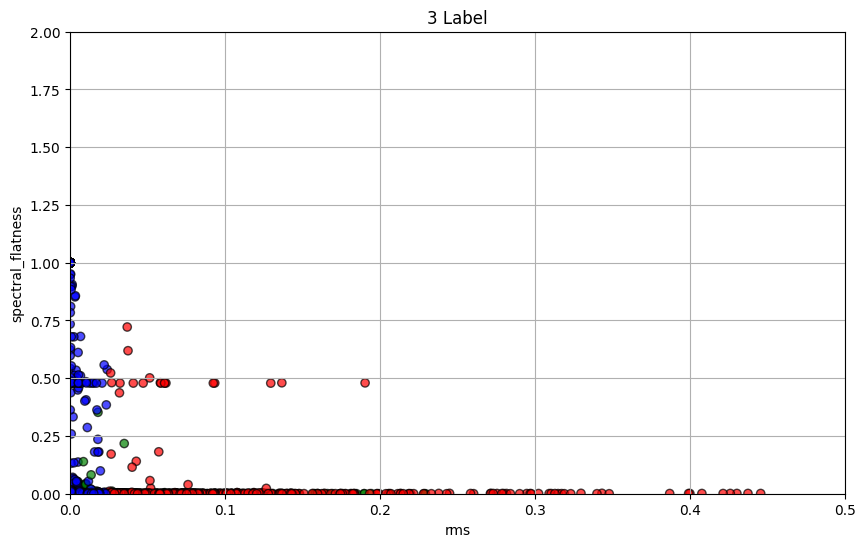

In [155]:
colors = df['label'].map({2: 'blue', 1: 'red', 0:'green'})

plt.figure(figsize=(10, 6))
plt.scatter(df['rms'], df['spectral_flatness'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('spectral_flatness')
plt.xlabel('rms')

# plt.xticks(np.arange(0, df['rms'].max() + 0.01, 0.01))
# plt.yticks(np.arange(0, df['spectral_flatness'].max() + 0.01, 0.01))

plt.xlim(0, 0.5)
plt.ylim(0, 2.0)
plt.grid(True, which='both')
plt.title("3 Label")
plt.show()

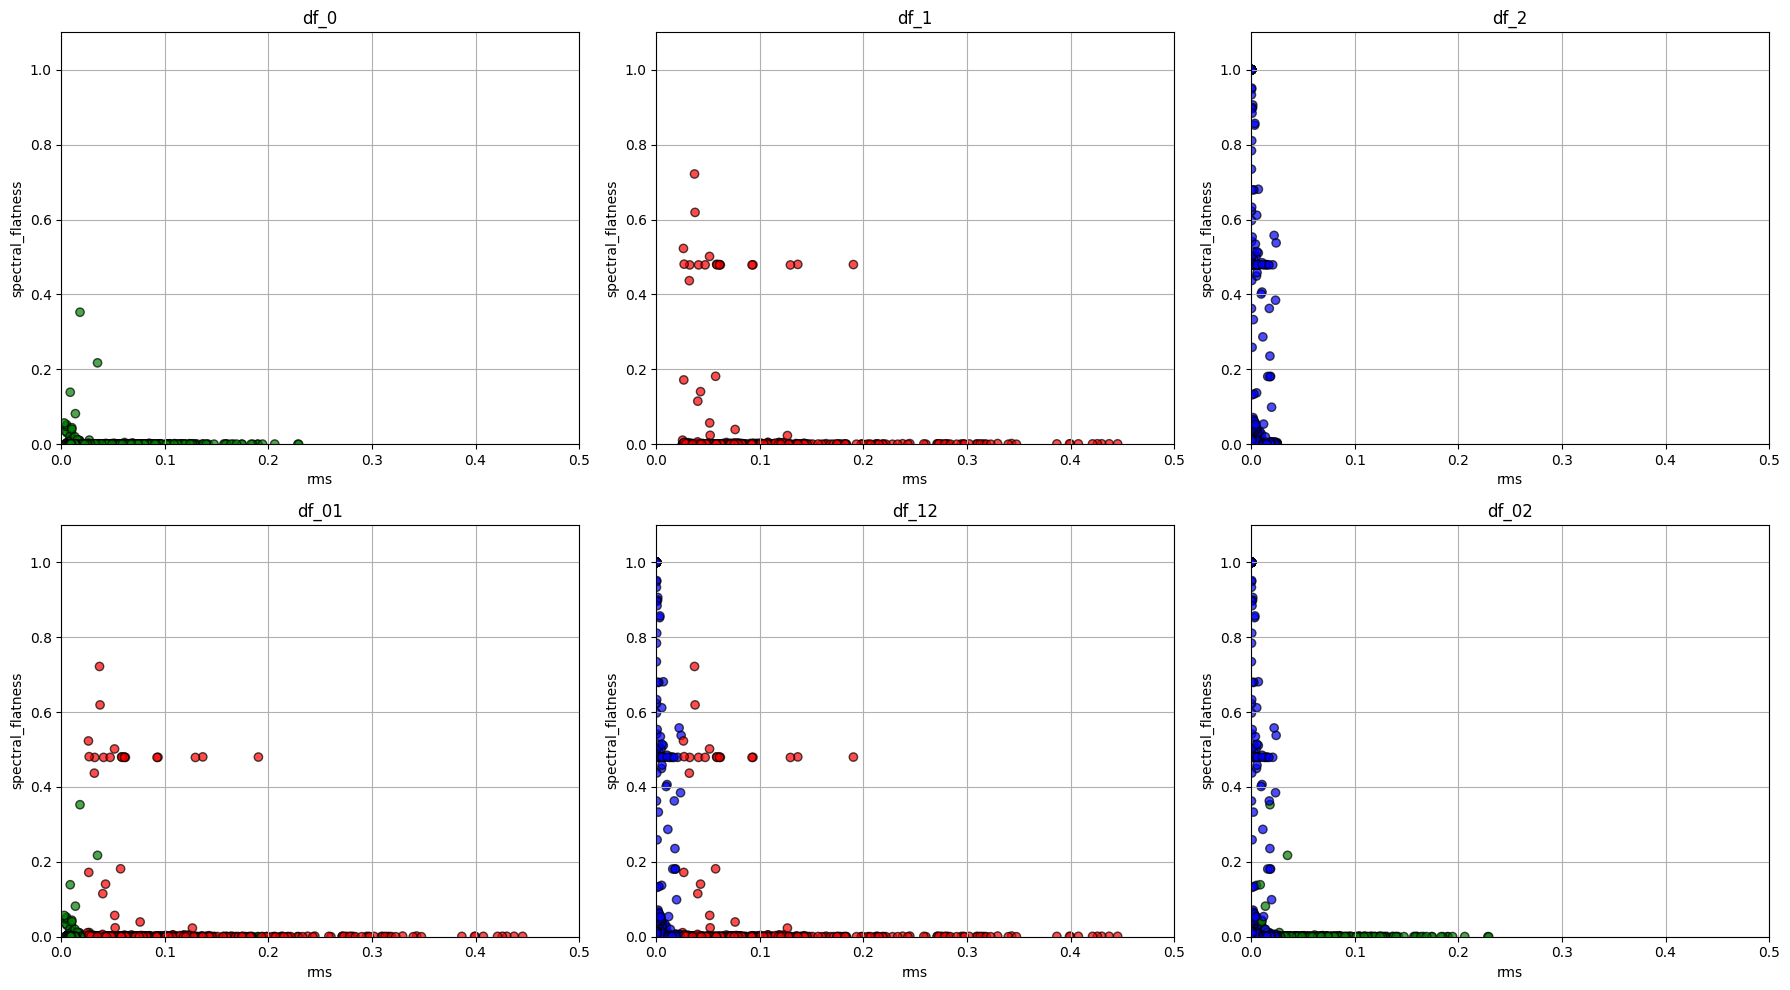

In [156]:
datasets = [df_0, df_1, df_2, df_01, df_12, df_02]
titles = ["df_0", "df_1", "df_2", "df_01", "df_12", "df_02"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (dataset, ax) in enumerate(zip(datasets, axes)):
    colors = dataset['label'].map({2: 'blue', 1: 'red', 0: 'green'})
    ax.scatter(dataset['rms'], dataset['spectral_flatness'], c=colors, alpha=0.7, edgecolors='k')
    ax.set_title(titles[i])
    ax.set_xlabel('rms')
    ax.set_ylabel('spectral_flatness')
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 1.1)
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

Asesmen Label Manual


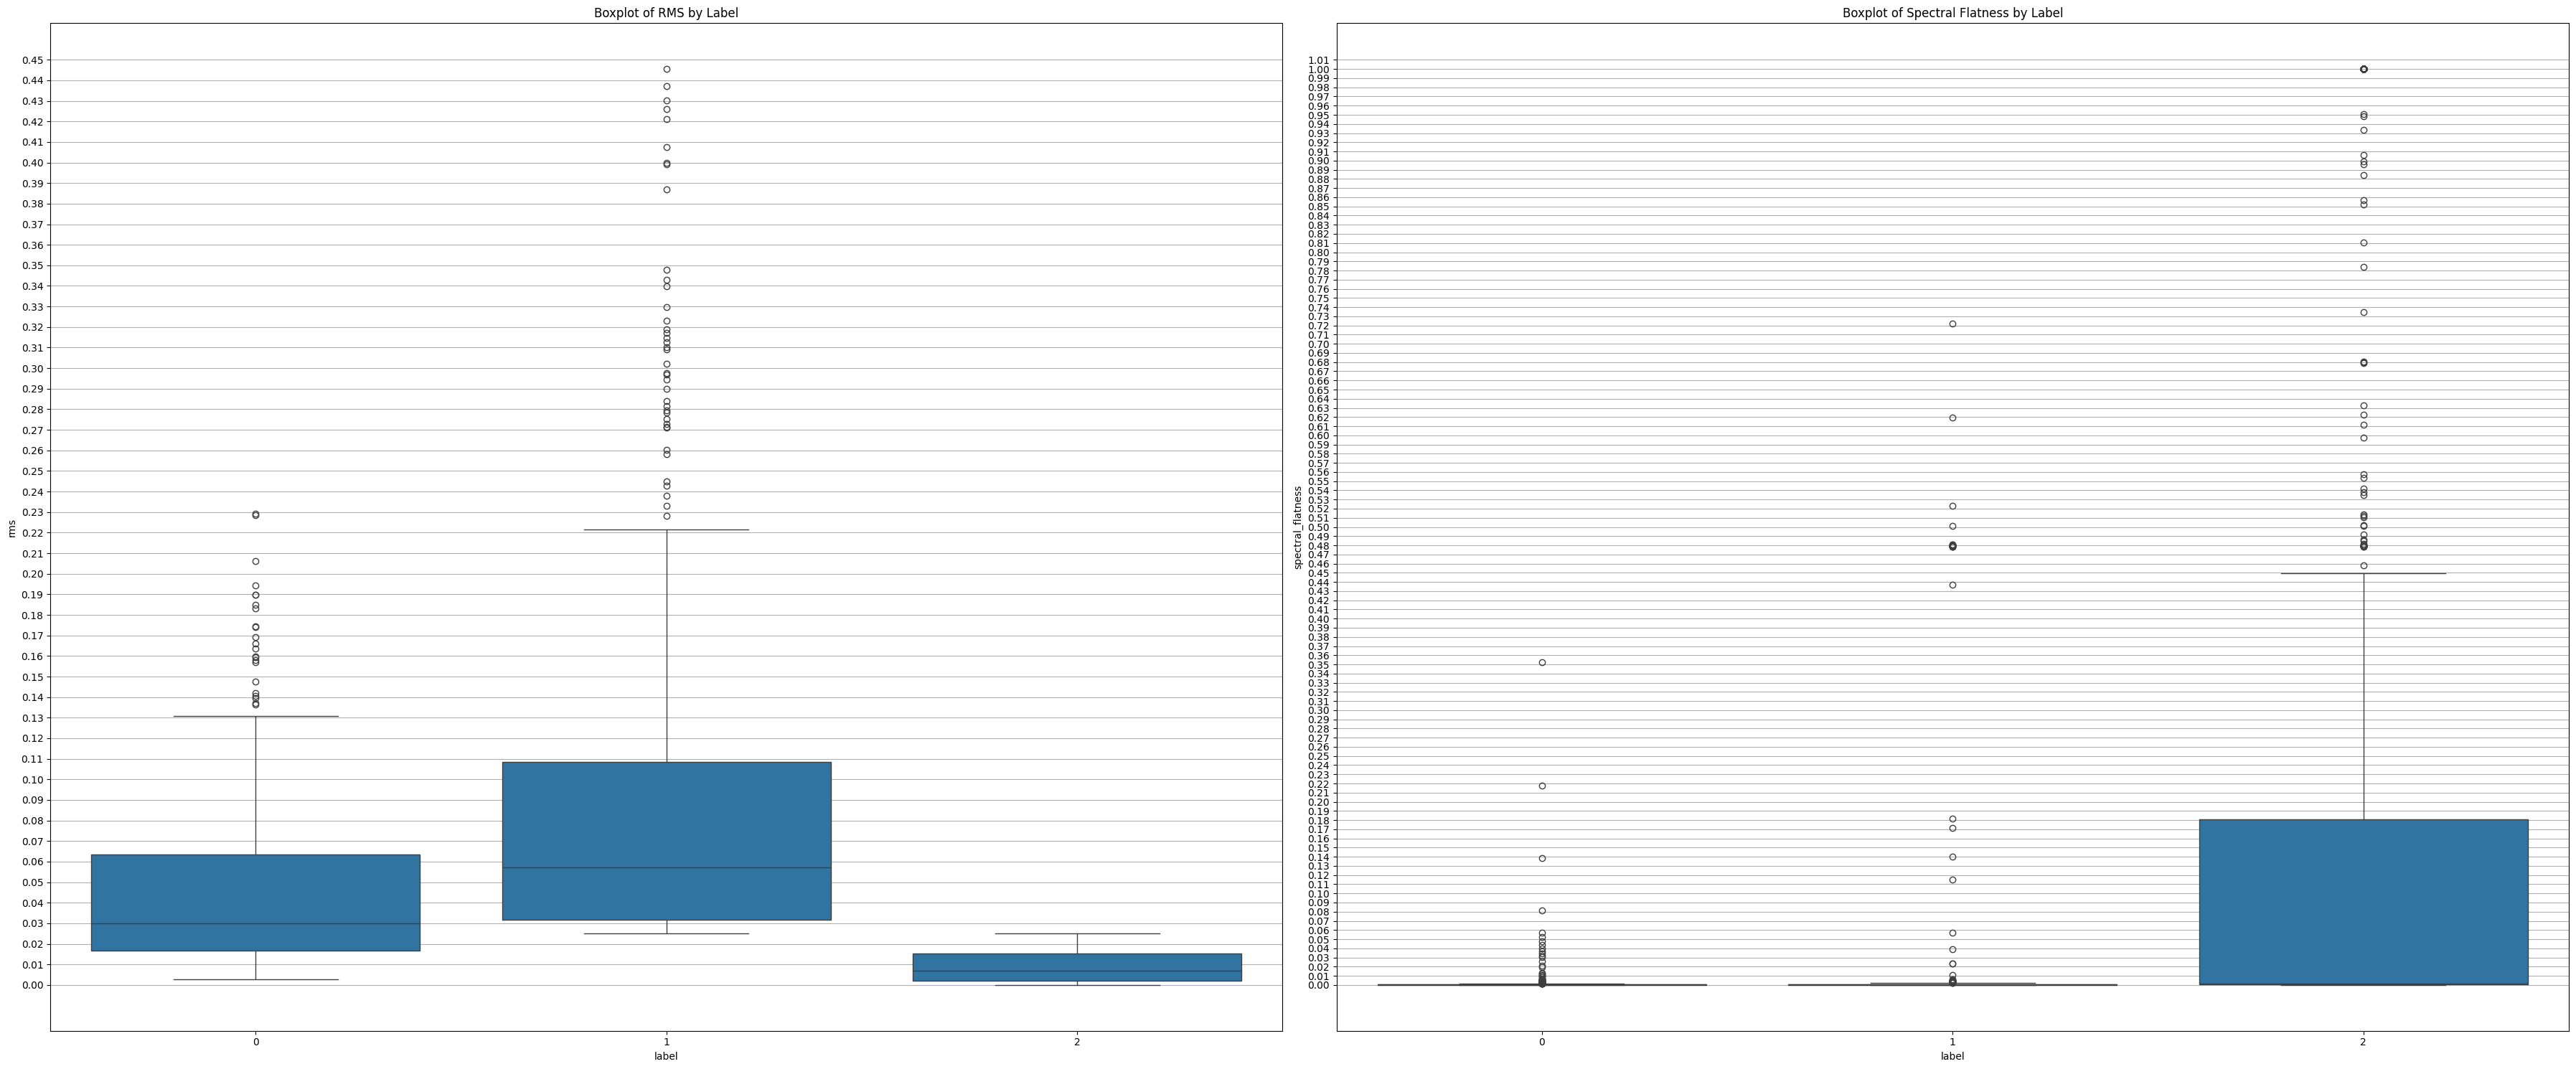

In [159]:
import seaborn as sns

plt.figure(figsize=(36, 15))

# RMS boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='rms', data=df)
plt.title('Boxplot of RMS by Label')
plt.grid(True, which='both', axis='y')
plt.yticks(np.arange(0, df['rms'].max() + 0.01, 0.01))

# Spectral Flatness boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='spectral_flatness', data=df)
plt.title('Boxplot of Spectral Flatness by Label')
plt.grid(True, which='both', axis='y')
plt.yticks(np.arange(0, df['spectral_flatness'].max() + 0.01, 0.01))

plt.tight_layout()
plt.show()

# Logistic Regression testing


In [57]:
dataset_fe

[{'nama': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'timestamp': [0.0, 1.0],
  'label': 2,
  'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
  'rms': 0.011059444,
  'zcr': 0.23255173703457446,
  'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
          -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
         [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
          -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
         [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
          -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
           7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
         [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
           5.2022276e+00,  3.3751645e+00, -6.7336679e+00],
         [

In [58]:
X = [(data["rms"], data["zcr"]) for data in dataset_fe]
y = [data["label"] for data in dataset_fe]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.662269129287599


array([[ 39,   2,  89],
       [ 10,  19,   6],
       [ 21,   0, 193]], dtype=int64)

In [60]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    color_map = {0: 'green', 1: 'red', 2: 'blue'}
    colors = [color_map[label] for label in y]
    
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')

    legend_elements = [
        Patch(facecolor='green', edgecolor='k', label='Suara Burung'),
        Patch(facecolor='Red', edgecolor='k', label='Suara Event Non-Burung'),
        Patch(facecolor='Blue', edgecolor='k', label='Suara Non-Event')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("RMS")
    plt.ylabel("ZCR")
    plt.title("Fitur RMS dan ZCR dengan Label")
    plt.show()

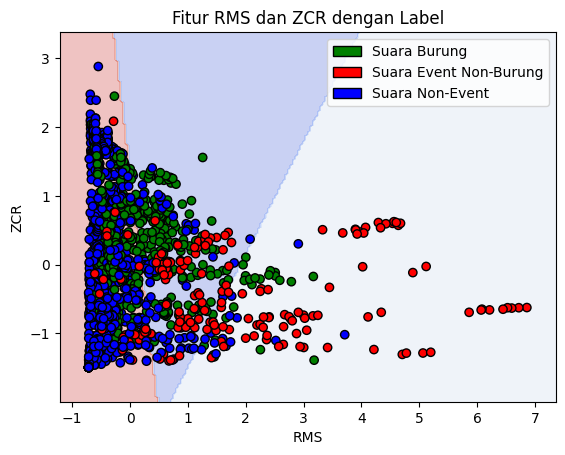

In [61]:
X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [62]:
X = [(data["rms"], data["zcr"]) for data in dataset_fe]
y_original = [data["label"] for data in dataset_fe]
y = [1 if label == 0 or label == 1 else 0 for label in y_original]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.7071240105540897


array([[186,  28],
       [ 83,  82]], dtype=int64)

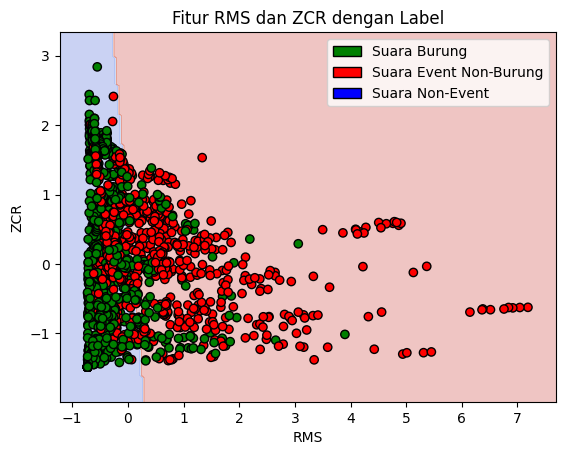

In [64]:
X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [65]:
print("Coefficients (weights) per class:")
print(model.coef_)

print("\nIntercepts (bias) per class:")
print(model.intercept_)

Coefficients (weights) per class:
[[1.49597642 0.15966259]]

Intercepts (bias) per class:
[-0.12079893]
